<a href="https://colab.research.google.com/github/Masaaaato/DynProfiler/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic data generation
We will create three time-series datasets with two features (feat1, feat2).  
However, one dataset will have anomalies added to feat1, and another group will have anomalies added to feat2.

In [ ]:
###########################################################
### 1. Generate 300 synthetic data with 2 features
###########################################################
import numpy as np

def create_time_series(group: int, n: int = 100, t=121):
    data = []
    for _ in range(n):
        tmp = []
        # feat1
        x = np.linspace(0, 6*np.pi, t)
        y = np.sin(x) + 0.6 * np.sin(2*x)
        if group == 1:
            y[40:81] *= 1.5
        y_noise = y + 0.2 * np.random.randn(t)
        tmp.append(y_noise)
        # feat2
        x = np.linspace(0, 4*np.pi, t)
        y = np.sin(x) + 0.5 * np.sin(3*x)
        if group == 2:
            y1 = np.sin(x) + 0.5 * np.sin(4*x)
            y[61:] = y1[61:]
        y_noise = y + 0.2 * np.random.randn(t)
        tmp.append(y_noise)
        tmp = np.stack(tmp, axis=0)
        data.append(tmp)
    data = np.stack(data, axis=0)
    return data


### Generate synthetic datasets
np.random.seed(10) # for reproducibility
data0 = create_time_series(group=0, n=100)
data1 = create_time_series(group=1, n=100)
data2 = create_time_series(group=2, n=100)
data = np.concatenate([data0, data1, data2], axis=0)
print("Generated data shape:", data.shape)
print(f"    --> This means we have {data.shape[0]} samples with ({data.shape[1]} features x {data.shape[2]} time-stamps).")

Generated data shape: (300, 2, 121)
    --> This means we have 300 samples with (2 features x 121 time-stamps).


In [ ]:
###########################################################
### 2. Create 100 other dynamics using FFT for each samnple assuming they are generated from other simulations or parameter sets
### Note: We used 30 parameter sets for each patient in the original paper.
###########################################################
import random
from scipy import fftpack

def create_aug(x: np.ndarray, n: int):
    # fast fourier transform (FFT)
    fft = np.stack([fftpack.fft(x[i, :]) for i in range(2)]) # apply FFT to each feature separately

    aug_arrs = []
    for _ in range(n):
        aug_arr = []
        for i in range(2):
            fft_amp = np.abs(fft[i] / (len(fft[i]) / 2))
            fft_aug = np.where(fft_amp >= 0.1, fft[i], 0)
            aug_x = fftpack.ifft(fft_aug)

            p = random.randint(100, 500) / 1000
            aug_x = aug_x.real + p * np.random.randn(121)
            aug_arr.append(aug_x)
        aug_arr = np.stack(aug_arr)
        aug_arrs.append(aug_arr)
    aug_arrs = np.stack(aug_arrs)
    return aug_arrs

### Generate augmented datasets
np.random.seed(10) # for reproducibility
aug_data = []
for sample in data:
    aug_data.append(create_aug(x=sample, n=100))
aug_data = np.stack(aug_data)
print("Augumented data shape:", aug_data.shape)
print(f"    --> This means we have {aug_data.shape[1]} augmented data for each of {aug_data.shape[0]} samples with ({data.shape[1]} features x {data.shape[2]} time-stamps).")

Augumented data shape: (300, 100, 2, 121)
    --> This means we have 100 augmented data for each of 300 samples with (2 features x 121 time-stamps).


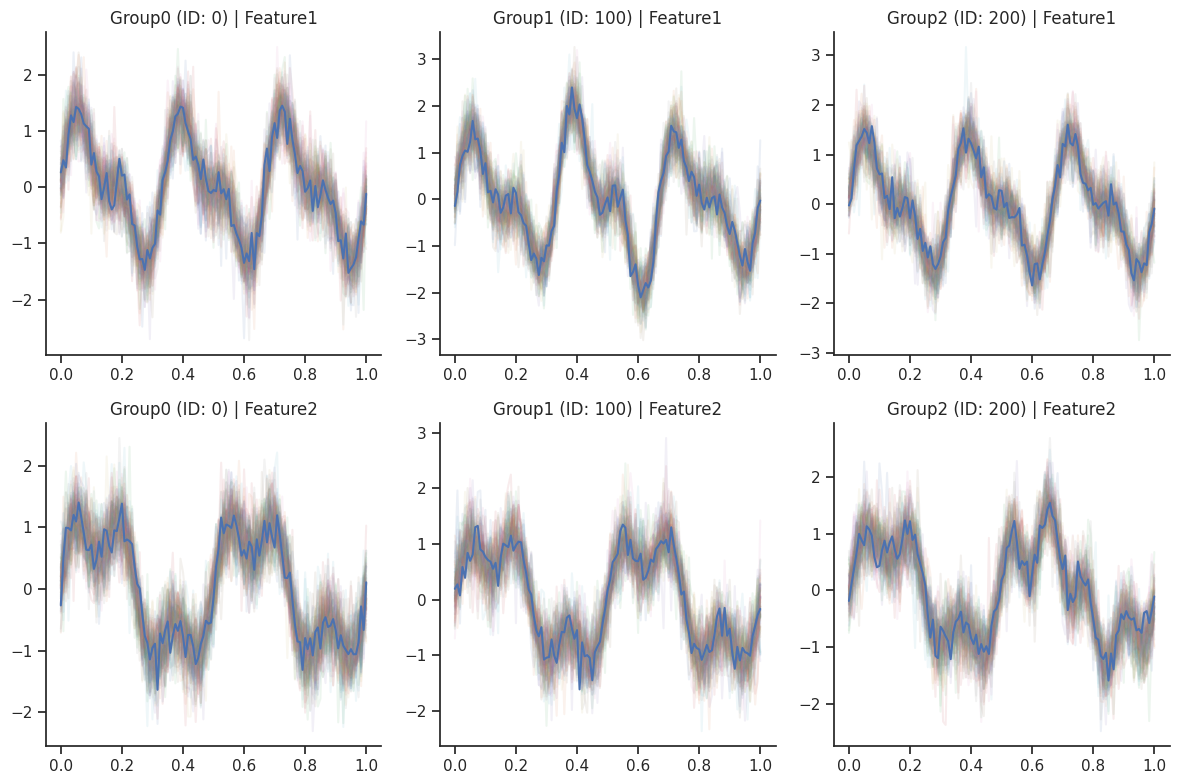

In [ ]:
###########################################################
### 3. Let's see the dynamics
###########################################################
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

sample_idx0 = 0
sample_idx1 = 100
sample_idx2 = 200
n_aug = 100

fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)
t = np.linspace(0, 1, 121)
for (i, sample_i) in enumerate([sample_idx0, sample_idx1, sample_idx2]):
    for j in range(n_aug):
        axes[0, i].plot(t, aug_data[sample_i, j, 0, :], alpha=0.1) # feature 1
        axes[1, i].plot(t, aug_data[sample_i, j, 1, :], alpha=0.1) # feature 2
    axes[0, i].plot(t, data[sample_i, 0, :])
    axes[1, i].plot(t, data[sample_i, 1, :])
    axes[0, i].set_title(f"Group{i} (ID: {sample_i}) | Feature1")
    axes[1, i].set_title(f"Group{i} (ID: {sample_i}) | Feature2")

fig.tight_layout()
plt.show()

In [ ]:
###########################################################
### 4. Get the input data
###########################################################
y_mean = aug_data.mean(axis=1)
y_std = aug_data.std(axis=1)

# Self-supervised learning

In [ ]:
!pip install -q captum umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/okadalabipr/DynProfiler.git

Cloning into 'DynProfiler'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 70 (delta 16), reused 44 (delta 8), pack-reused 0
Receiving objects: 100% (70/70), 6.07 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
########################
### 1. Training
########################
import os
import sys
from argparse import Namespace
import yaml
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from umap import UMAP
# Load DynProfiler
sys.path.append("/content/DynProfiler")
import dynprofiler as dynpro

# Please change the setting according to your purpose
base_path = "/content/DynProfiler/data"
train_params = yaml.safe_load(open(os.path.join(base_path, "inputs", "train_params.yml")))
model_params = yaml.safe_load(open(os.path.join(base_path, "inputs", "model_params.yml")))
dataset_params = yaml.safe_load(open(os.path.join(base_path, "inputs", "dataset_params.yml")))

outdir = os.path.join(base_path, "outputs")
dynpro.embed({"mean": y_mean, "std": y_std},
             outdir,
             **train_params, **model_params, **dataset_params)

Epoch: [10] Elapsed 0m 5s Loss: -0.7353 LR: 0.001000  
Epoch: [20] Elapsed 0m 9s Loss: -0.7960 LR: 0.001000  
Epoch: [30] Elapsed 0m 13s Loss: -0.8457 LR: 0.001000  
Epoch: [40] Elapsed 0m 17s Loss: -0.8754 LR: 0.001000  
Epoch: [50] Elapsed 0m 21s Loss: -0.8841 LR: 0.001000  
Epoch: [60] Elapsed 0m 25s Loss: -0.9134 LR: 0.001000  
Epoch: [70] Elapsed 0m 29s Loss: -0.9299 LR: 0.001000  
Epoch: [80] Elapsed 0m 32s Loss: -0.9450 LR: 0.001000  
Epoch: [90] Elapsed 0m 36s Loss: -0.9747 LR: 0.001000  
Epoch: [100] Elapsed 0m 40s Loss: -0.9905 LR: 0.001000  
Epoch: [110] Elapsed 0m 44s Loss: -0.9884 LR: 0.001000  
Epoch: [120] Elapsed 0m 48s Loss: -0.9955 LR: 0.001000  
Epoch: [130] Elapsed 0m 52s Loss: -0.9976 LR: 0.001000  
Epoch: [140] Elapsed 0m 56s Loss: -0.9979 LR: 0.001000  
Epoch: [150] Elapsed 1m 0s Loss: -0.9983 LR: 0.001000  
Epoch: [160] Elapsed 1m 3s Loss: -0.9984 LR: 0.001000  
Epoch: [170] Elapsed 1m 7s Loss: -0.9988 LR: 0.001000  
Epoch: [180] Elapsed 1m 11s Loss: -0.9964 LR:

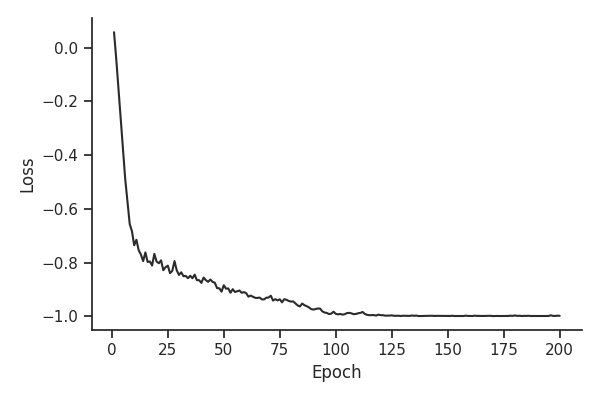

In [ ]:
# Check the training history
from IPython.display import Image, display_png
display_png(Image(os.path.join(base_path, "outputs", "Tutorial_train_log.png")))

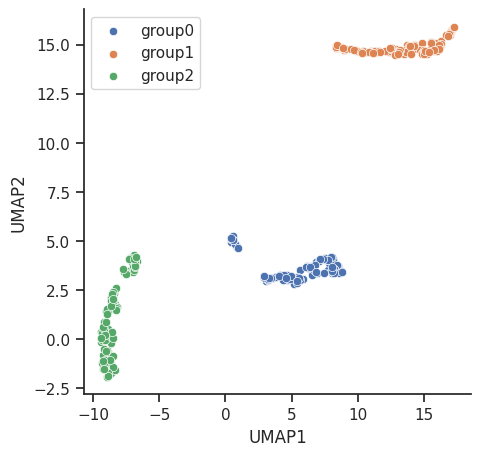

In [ ]:
################################################
### 2. Check the 2D visualization of the resulting embeddings
################################################
embeds = np.load(os.path.join(base_path, "outputs", "Tutorial_1DCNN_SimSiam_seed10_epochs200.npy"))

# Dimension reduction using UMAP
embeds_2d = UMAP(random_state=0).fit_transform(embeds)

# Visualization
fig, ax = plt.subplots(figsize=(5,5))
n_samples_per_group = 100
for i in range(3):
    sns.scatterplot(x=embeds_2d[n_samples_per_group*i:n_samples_per_group*(i+1), 0],
                    y=embeds_2d[n_samples_per_group*i:n_samples_per_group*(i+1), 1],
                    label=f"group{i}", ax=ax)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.legend()
plt.show()

# Classification
You can define classes according to clustering, such as [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), for the previous embeddings.  
However, we do not perform clustering since the groups are obviously separated in this case.

In [ ]:
##########################
### 1. Define labels
### Note: Clustering is not performed since the groups are obviously separated in this case as you can see in the previous 2D visualization.
##########################
labels = np.array([0]*n_samples_per_group + [1]*n_samples_per_group + [2]*n_samples_per_group)

In [ ]:
##########################
### 2. Supervised Learning
##########################
train_params["pretrained_path"] = os.path.join(base_path, "outputs", "Tutorial_1DCNN_SimSiam_seed10_epochs200.pth")
dynpro.interpret({"mean": y_mean},
                 outdir,
                 labels,
                 **train_params, **model_params, **dataset_params)

------------------------------------------------------------
-------------------- Traning Fold 0 --------------------
------------------------------------------------------------
Epoch: [5] Elapsed 0m 2s Train Loss: 0.6522 Valid Loss: 0.6102 Score: 1.0000 LR: 0.001000  
Epoch: [10] Elapsed 0m 4s Train Loss: 0.4725 Valid Loss: 0.4360 Score: 1.0000 LR: 0.001000  
Epoch: [15] Elapsed 0m 6s Train Loss: 0.3764 Valid Loss: 0.3316 Score: 1.0000 LR: 0.001000  
Epoch: [20] Elapsed 0m 9s Train Loss: 0.3037 Valid Loss: 0.2776 Score: 1.0000 LR: 0.001000  
Epoch: [25] Elapsed 0m 11s Train Loss: 0.2540 Valid Loss: 0.2306 Score: 1.0000 LR: 0.001000  
Epoch: [30] Elapsed 0m 12s Train Loss: 0.2252 Valid Loss: 0.1894 Score: 1.0000 LR: 0.001000  
Epoch: [35] Elapsed 0m 14s Train Loss: 0.2216 Valid Loss: 0.1618 Score: 1.0000 LR: 0.001000  
Epoch: [40] Elapsed 0m 16s Train Loss: 0.1695 Valid Loss: 0.1474 Score: 1.0000 LR: 0.001000  
Epoch: [45] Elapsed 0m 18s Train Loss: 0.1688 Valid Loss: 0.1260 Score: 1.

# Extraction of important dynamics

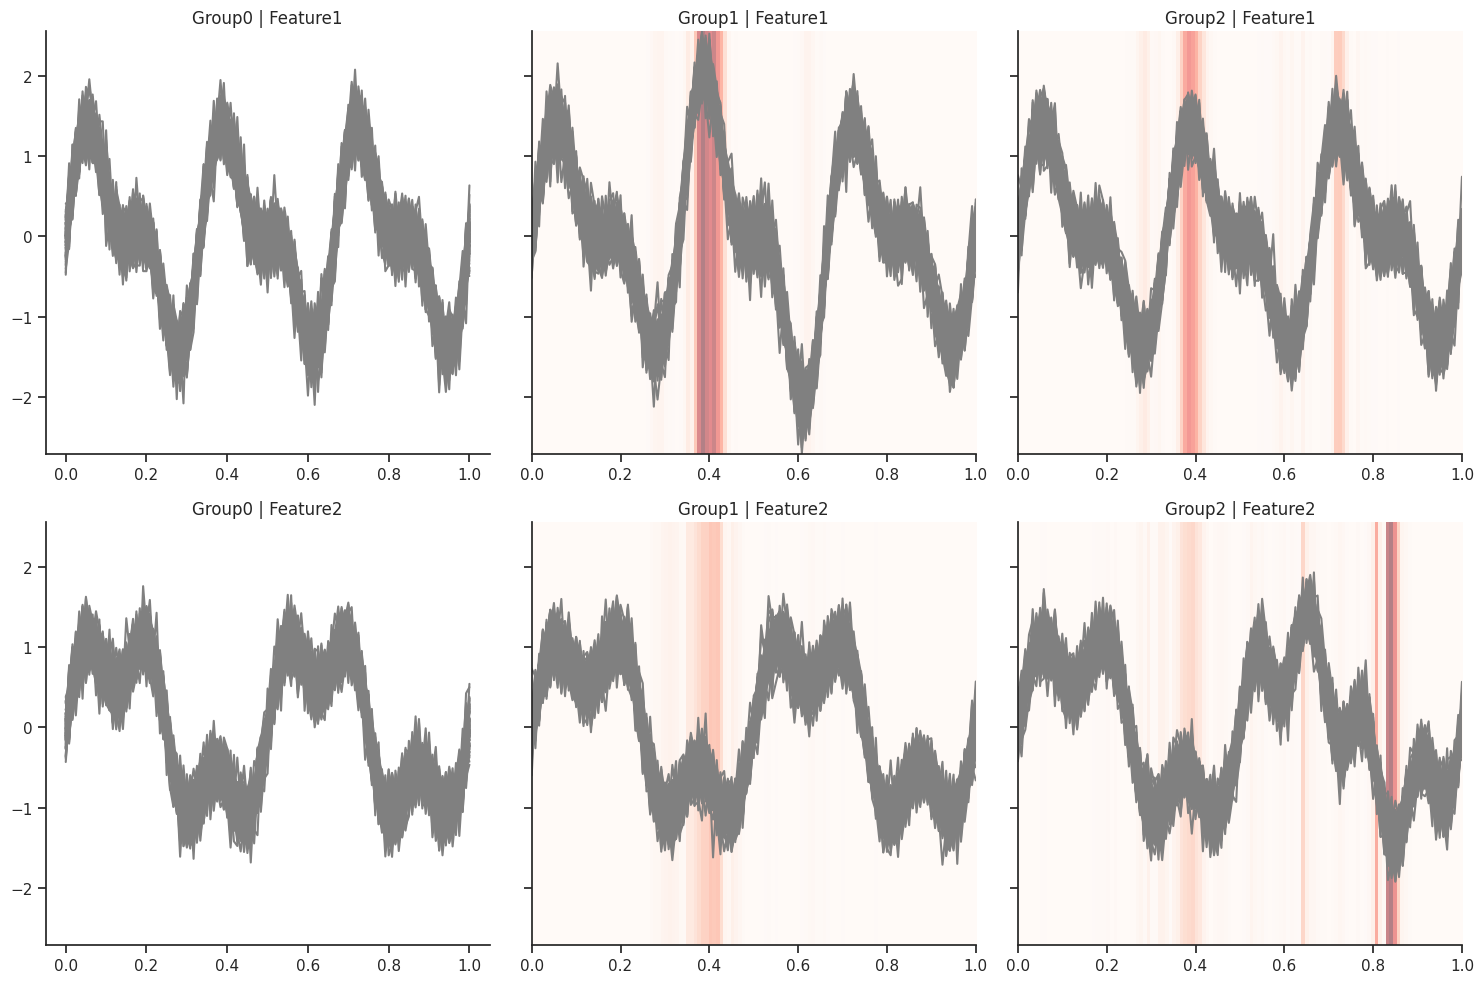

In [ ]:
###############################################
### 1. Load time-dependent contributions to the previous classification
###############################################
attrs1 = np.load(os.path.join(base_path, "outputs", "Tutorial_1DCNN_seed10_attribution_class1.npy")) # For class1
attrs2 = np.load(os.path.join(base_path, "outputs", "Tutorial_1DCNN_seed10_attribution_class2.npy")) # For class2

###############################################
### 2. Visualization
###############################################
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=2, sharey=True)
t = np.linspace(0, 1, 121)

# This can be ignored.
attrs1 = np.abs(attrs1)
attrs2 = np.abs(attrs2)

mn, mx = data[:, 0, :].min(), data[:, 0, :].max()

for i in range(2):
    axes[i, 1].imshow([attrs1[i]], cmap='Reds', aspect='auto',
                        extent=(t[0], t[-1], mn, mx),
                        alpha=0.5, vmin=0, vmax=1)
    axes[i, 2].imshow([attrs2[i]], cmap='Reds', aspect='auto',
                        extent=(t[0], t[-1], mn, mx),
                        alpha=0.5, vmin=0, vmax=1)

for i in range(3):
    for j in range(n_samples_per_group*i, n_samples_per_group*(i+1)):
        axes[0, i].plot(t, data[j, 0, :], c="grey")
        axes[1, i].plot(t, data[j, 1, :], c="grey")
    axes[0, i].set_title(f"Group{i} | Feature1")
    axes[1, i].set_title(f"Group{i} | Feature2")


fig.tight_layout()
plt.show()

You can see that the model distinguished between Group1 and Group2 largely from feature1 and feature2, respectively.